# Recommendation System with Matrix Factorisation

This notebook will be used to create a Recommendation System. Specifically, we'll be using matrix factoriszation to learn user and movie embeddings. We will create a movie recommendation system based on the MovieLens dataset. The data consists of movies ratings (on a scale of 1 to 5) given by users.


In [1]:
import pandas as pd
import numpy as np
import collections
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

## Download the dataset

In [3]:
# Download movielens data
from urllib.request import urlretrieve
import zipfile

print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


## Read from source and convert to dataframe

In [4]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))

users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [5]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596


In [6]:
# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
# Also getting the year from release date
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995


## EDA and Feature Engineering

In [7]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [8]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [9]:
# Merge movie, rating and user dataset
movieslens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movieslens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.000,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.000,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Action,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.000,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Romance,Comedy-Romance,49,M,writer,55105
3,195,24,4.000,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.000,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [10]:
def split_dataframe(df, holdout_fraction=0.1):
    """
    Splits a DataFrame into training and test sets.
    Args:
        df: a dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
        train: dataframe for training
        test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

# Part 2: Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



#### 2.1 Build a tf.SparseTensor representation of the Rating Matrix

In [11]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

#### 2.2 Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.


### 2.2.1 Mean Squared Error
TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Notes:
  * we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.


In [12]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_enbeddings):
    """
    Args:
        sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
        user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
        dimension, such that U_i is the embedding of user i.
        movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
        dimension, such that V_j is the embedding of movie j.
    Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
    """
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_enbeddings, sparse_ratings.indices[:, 1]),
        axis=1
    )
    
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss



## Part 3: Training a Matrix Factorization model

#### 3.1 CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [13]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

#### 3.2 Build a Matrix Factorization model and train it

Using the `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [14]:
#@title Solution
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
      ratings: a DataFrame of the ratings
      embedding_dim: the dimension of the embedding vectors.
      init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
      model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "user_id": U,
        "movie_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

2024-06-07 11:03:01.482599: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-07 11:03:01.482624: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-07 11:03:01.482630: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-07 11:03:01.482647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-07 11:03:01.482661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-07 11:03:01.486326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-07 11:03:01.488209: I tensorflow/core/gr

 iteration 1000: train_error=0.375881, test_error=1.381609

[{'train_error': 0.37588072, 'test_error': 1.3816093}]

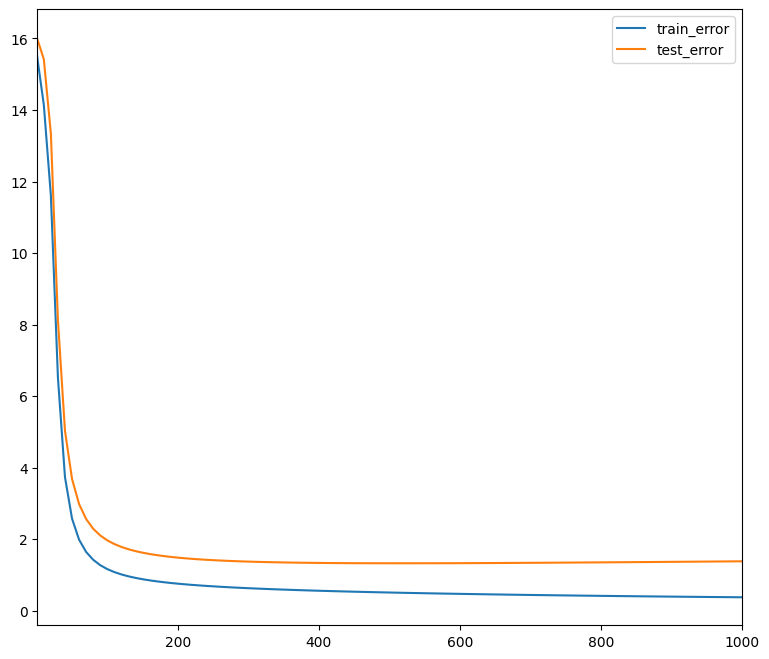

In [15]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

## Part 4. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.


#### 4.1 Compute the scores of the candidates
Write a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.


Compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Notes:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [16]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.


## Part 5. User recommendations and nearest neighbors

In [17]:
# Movie recommendations - nearest neighbours
def movie_neighbors(model, title_substring, measure=DOT, k=6):
    # Search for movie ids that match the given substring.
    ids =  movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values

    if len(titles) == 0:
      raise ValueError("Found no movies with title %s" % title_substring)
    
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
      print("[Found more than one matching movie. Other candidates: {}]".format(", ".join(titles[1:])))

    movie_id = ids[0]
    scores = compute_scores(
        model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
        measure)
    score_key = measure + ' score'
    
    df = pd.DataFrame({
        score_key: list(scores),
        'titles': movies['title'],
        'genres': movies['all_genres']
    })
    
    print(f"\n \n -------------------------------------------\n {df.sort_values([score_key], ascending=False).head(k)}\n\n -------------------------------------------\n")



#### 5.1 Movie recommendations based on a movie

In [18]:
movie_neighbors(model, "Toy Story", DOT)


Nearest neighbors of : Toy Story (1995).

 
 -------------------------------------------
      dot score                                   titles  \
962      5.895  Some Folks Call It a Sling Blade (1993)   
0        5.655                         Toy Story (1995)   
49       5.551                         Star Wars (1977)   
173      5.440           Raiders of the Lost Ark (1981)   
658      5.383              Arsenic and Old Lace (1944)   
168      5.190               Wrong Trousers, The (1993)   

                                  genres  
962                       Drama-Thriller  
0              Animation-Children-Comedy  
49   Action-Adventure-Romance-Sci-Fi-War  
173                     Action-Adventure  
658              Comedy-Mystery-Thriller  
168                     Animation-Comedy  

 -------------------------------------------



In [19]:
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]

 
 -------------------------------------------
      cosine score                                     titles  \
94          1.000                             Aladdin (1992)   
63          0.853           Shawshank Redemption, The (1994)   
193         0.846                          Sting, The (1973)   
21          0.836                          Braveheart (1995)   
173         0.835             Raiders of the Lost Ark (1981)   
209         0.827  Indiana Jones and the Last Crusade (1989)   

                                genres  
94   Animation-Children-Comedy-Musical  
63                               Drama  
193                       Comedy-Crime  
21                    Action-Drama-War  
173                   Action-Adventure  
209                   Action-Adventure  

 -------------------------------------------



## Observations

- It seems that the quality of learned embeddings may not be very good. 
- The recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items.


Note: A separate notebook will add regularisation and attempt to improve the quality of recommendations